# ディープラーニングでタッチの達也と和哉の分類をする

## 画像のリサイズ
参考: https://note.nkmk.me/python-pillow-image-resize/

In [3]:
import os
import glob
import re
import copy
import pickle

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.utils.np_utils import to_categorical

In [3]:
files = glob.glob('../images/touch_comic/original/*.png')

for f in files:
    img = Image.open(f)
    img_resize = img.resize((128, 128))
    ftitle, fext = os.path.splitext(f)
    img_resize.save(ftitle + '_resized' + fext)

## data augumentationを用いて学習データを生成

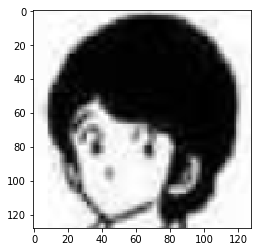

In [4]:
img = load_img("../images/touch_comic/original/kazuya1_resized.png", grayscale=True)
plt.imshow(img, cmap='gray')
plt.show()

In [14]:
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x.shape

(1, 128, 128, 1)

In [11]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
ftitle, fext = os.path.splitext(glob.glob("../images/touch_comic/original/kazuya1_resized.png")[0])
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='.', save_prefix=ftitle, save_format='png'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

### 全ての画像を処理  いらない？

In [22]:
files = glob.glob('../images/touch_comic/*_resized.png')

for f in files:
    ftitle, fext = os.path.splitext(f)
    img = load_img(f, grayscale=True)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir='.', save_prefix=ftitle, save_format='png'):
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely

## 画像を取り込む 再開はここから

In [3]:
K.backend(), K.image_dim_ordering()

img_array = []
label = []

files = glob.glob('../images/touch_comic/*.png')

for f in files:
    img_array.append(img_to_array(load_img(f, grayscale=True)))
    label.append(re.findall(r"(kazuya|tatsuya)", f)[0])

In [4]:
img_nparray = np.array(img_array) / 255
label = np.array(label)

In [5]:
label[0]

'tatsuya'

In [26]:
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(label)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

NameError: name 'label' is not defined

In [7]:
X_train, X_test, y_train, y_test = train_test_split(img_nparray, onehot_encoded, random_state=42, test_size=0.1)

In [8]:
X_train.shape

(396, 128, 128, 1)

### validation画像読み込み

In [9]:
K.backend(), K.image_dim_ordering()

img_array = []
label = []

files = glob.glob('../images/touch_comic/*.png')

for f in files:
    img_array.append(img_to_array(load_img(f, grayscale=True)))
    label.append(re.findall(r"(kazuya|tatsuya)", f)[0])
    
X_test = np.array(img_array) / 255
label = np.array(label)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(label)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

y_test = onehot_encoded

In [11]:
batch_size = 32
epochs = 300


model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

model.fit_generator(datagen.flow(X_train, y_train,
                        batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=2,
                        validation_data=(X_test, y_test))

Epoch 1/300
2/2 [==============================] - 2s - loss: 0.8104 - acc: 0.5625 - val_loss: 0.8984 - val_acc: 0.5000
Epoch 2/300
2/2 [==============================] - 0s - loss: 1.0598 - acc: 0.5781 - val_loss: 0.6856 - val_acc: 0.5250
Epoch 3/300
2/2 [==============================] - 0s - loss: 0.7394 - acc: 0.5000 - val_loss: 0.6897 - val_acc: 0.5136
Epoch 4/300
2/2 [==============================] - 0s - loss: 0.6952 - acc: 0.4531 - val_loss: 0.6908 - val_acc: 0.5864
Epoch 5/300
2/2 [==============================] - 0s - loss: 0.6913 - acc: 0.5156 - val_loss: 0.6912 - val_acc: 0.5818
Epoch 6/300
2/2 [==============================] - 0s - loss: 0.6956 - acc: 0.6094 - val_loss: 0.6915 - val_acc: 0.5000
Epoch 7/300
2/2 [==============================] - 1s - loss: 0.6976 - acc: 0.5186 - val_loss: 0.6918 - val_acc: 0.5068
Epoch 8/300
2/2 [==============================] - 0s - loss: 0.6913 - acc: 0.5781 - val_loss: 0.6918 - val_acc: 0.5705
Epoch 9/300
2/2 [=======================

2/2 [==============================] - 0s - loss: 0.1969 - acc: 0.9531 - val_loss: 0.1046 - val_acc: 0.9841
Epoch 136/300
2/2 [==============================] - 0s - loss: 0.1872 - acc: 0.9219 - val_loss: 0.1932 - val_acc: 0.9341
Epoch 137/300
2/2 [==============================] - 0s - loss: 0.1948 - acc: 0.9280 - val_loss: 0.1765 - val_acc: 0.9386
Epoch 138/300
2/2 [==============================] - 0s - loss: 0.2204 - acc: 0.9375 - val_loss: 0.1142 - val_acc: 0.9659
Epoch 139/300
2/2 [==============================] - 0s - loss: 0.3117 - acc: 0.8906 - val_loss: 0.0946 - val_acc: 0.9750
Epoch 140/300
2/2 [==============================] - 0s - loss: 0.1764 - acc: 0.9531 - val_loss: 0.0886 - val_acc: 0.9750
Epoch 141/300
2/2 [==============================] - 0s - loss: 0.1664 - acc: 0.9375 - val_loss: 0.0958 - val_acc: 0.9727
Epoch 142/300
2/2 [==============================] - 0s - loss: 0.2255 - acc: 0.8906 - val_loss: 0.0811 - val_acc: 0.9795
Epoch 143/300
2/2 [===================

2/2 [==============================] - 0s - loss: 0.1863 - acc: 0.9219 - val_loss: 0.0081 - val_acc: 1.0000
Epoch 270/300
2/2 [==============================] - 0s - loss: 0.0517 - acc: 0.9844 - val_loss: 0.0156 - val_acc: 1.0000
Epoch 271/300
2/2 [==============================] - 0s - loss: 0.0251 - acc: 1.0000 - val_loss: 0.0278 - val_acc: 0.9955
Epoch 272/300
2/2 [==============================] - 0s - loss: 0.1020 - acc: 0.9844 - val_loss: 0.0149 - val_acc: 1.0000
Epoch 273/300
2/2 [==============================] - 0s - loss: 0.1099 - acc: 0.9820 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 274/300
2/2 [==============================] - 0s - loss: 0.0457 - acc: 0.9844 - val_loss: 0.0093 - val_acc: 0.9977
Epoch 275/300
2/2 [==============================] - 0s - loss: 0.0862 - acc: 0.9688 - val_loss: 0.0070 - val_acc: 0.9977
Epoch 276/300
2/2 [==============================] - 0s - loss: 0.0210 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 277/300
2/2 [===================

## データの保存とロード

In [13]:
# Save model and weights

model.save('../images/touch_comic/touch.h5')
print('Saved trained model')


Saved trained model


In [7]:
model = load_model('../images/touch_comic/touch.h5')

/Users/hidehiro/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/keras/models.py:288: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## モデルを使って試してみる

In [41]:
files = sorted(glob.glob('../images/touch_comic/test/Screen*.png'))

for f in files:
    img = Image.open(f)
    img_resize = img.resize((128, 128))
    ftitle, fext = os.path.splitext(f)
    ftitle = ftitle.replace('Screen', '')
    img_resize.save(ftitle + '_resized' + fext)

In [42]:
img_test = []
label_test = []

files = sorted(glob.glob('../images/touch_comic/test/*_resized.png'))

for f in files:
    img_test.append(img_to_array(load_img(f, grayscale=True)))
#     label_test.append(re.findall(r"(kazuya|tatsuya)", f)[0])
    
img_nparray_test = np.array(img_test) / 255

predict = model.predict(img_nparray_test)

In [37]:
len(predict)

7

In [43]:
predict_label = []
labels = ['kazuya', 'tatusya']

for i in range(len(predict)):
    predict_label.append(labels[np.argmax(predict[i])])

In [44]:
predict_label

['tatusya',
 'tatusya',
 'tatusya',
 'kazuya',
 'tatusya',
 'kazuya',
 'tatusya',
 'kazuya']

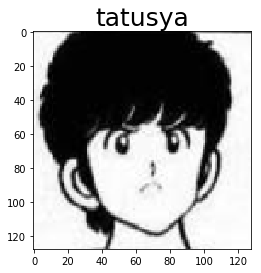

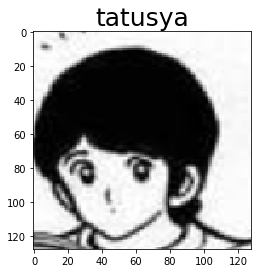

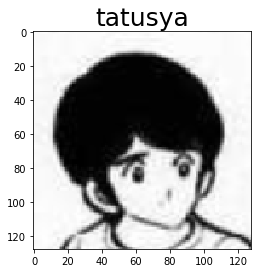

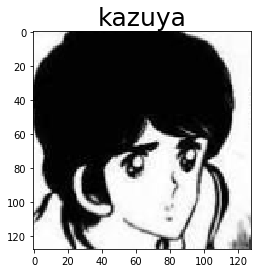

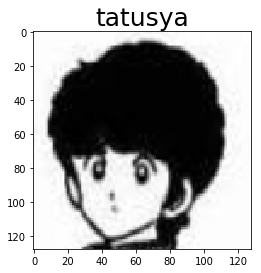

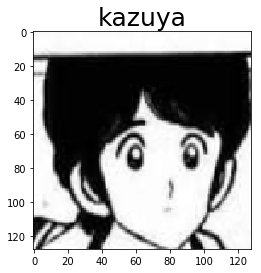

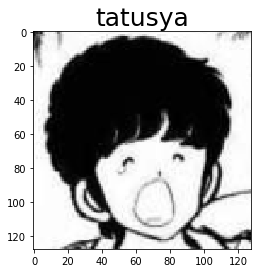

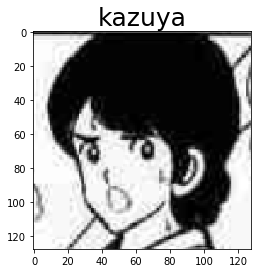

In [45]:
for i, f in enumerate(files):
    img = load_img(f, grayscale=True)
    plt.imshow(img, cmap='gray')
    plt.title(predict_label[i], fontsize=25)
    plt.show()